# Chapter 4, Exercise 1, Second Attempt: Implement your own Learner

> Create your own implmentation of Learner from scratch, based on the training loop shown in this chapter.

As a reminder, the loop is:

- Init
- Predict
- Loss 
- Gradient
- Step
- Stop

My first notebook did not behave well, and seemed like a mess.  I decided to try again.

The approach in this notebook came from [this forum post](https://forums.fast.ai/t/chapter-4-further-research-building-a-learner-from-scratch/78474), and seems to be the only discussion of this exercise on the forum.  The implementation is a great deal simpler than mine, so I thought it was worth trying.

The poster was asking about one problem they encountered:

> I have used the SGD directly as my optimizer, when I fit the learner without the “self.opt.zero_grad” step in the “train_epoch” method it works fine(getting me a score above 0.96 - 0.97- which it should actually do) but when I run it with the “self.opt.zero_grad” step it kind of sticks at one point getting a value eg:0.4957 for “n” number of epochs.

That is:

- using SGD directly, with the `opt.zero_grad()` line in `train_epoch` commented out, accuracy is ~ 0.91 as expected;
- when uncommenting `opt.zero_grad()`, accuracy gets stuck

I did note what looks like double sigmoid: it's in the last layer of the model, *and* it's in the class methods.  I decided to experiment with this.

Let's start with the boilerplate:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # Life, the Universe, and Everything

Let's create our model.  [Weights are  initialized for us](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear).

This is where I began experimenting:  I have one model with a final sigmoid layer, and one without.

In [2]:
my_model_with_sigmoid = nn.Sequential(
    nn.Linear(in_features=28*28, out_features=30),
    nn.ReLU(),
    nn.Linear(30, 1),
    nn.Sigmoid()
)

my_model_without_sigmoid = nn.Sequential(
    nn.Linear(in_features=28*28, out_features=30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

Load the FastAI 3/7 data set...

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)

training_3 = torch.stack([tensor(Image.open(o)) for o in (path /'train/3').ls().sorted()]).float() / 255.0
training_7 = torch.stack([tensor(Image.open(o)) for o in (path /'train/7').ls().sorted()]).float() / 255.0

len(training_3), len(training_7)

(6131, 6265)

Let's load those into tensors and create the training dataset:

In [4]:
train_x = torch.cat([training_3, training_7]).view(-1, 28*28)
train_y = tensor([1] * len(training_3) + [0] * len(training_7))

dset = list(zip(train_x, train_y))

train_x.shape, train_y.shape, len(dset)

(torch.Size([12396, 784]), torch.Size([12396]), 12396)

Now the validation dataset:

In [5]:
valid_3 = torch.stack([tensor(Image.open(o)) for o in (path / 'valid/3').ls().sorted()]).float() / 255.0
valid_7 = torch.stack([tensor(Image.open(o)) for o in (path / 'valid/7').ls().sorted()]).float() / 255.0

valid_x = torch.cat([valid_3, valid_7]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3) + [0] * len(valid_7))

valid_dset = list(zip(valid_x, valid_y))

valid_x.shape, valid_y.shape, len(valid_dset)

(torch.Size([2038, 784]), torch.Size([2038]), 2038)

Now the training data loader:

In [6]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256]))

...and the validation data loader;

In [7]:
valid_dl = DataLoader(valid_dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256]))

Next up would be optimizer.  I'm going to use the PyTorch SGD optimizer here:

In [8]:
my_optimizer = optim.SGD

Now it's time to try some training!

In this class, I wanted to have the flexibility to try a few different options.  Thus, the initialization arguments include `sigmoid` (whether or not we should appply sigmoid function to predictions), and `zero_grad` (whether or not we should zero gradients between backward propagations).

I've also added a list, `valid_loss`, of the validation loss at each epoch; we'll plot that later on.

In [9]:
class MyLearner():
    
    def __init__(self, dl, model, opt, sigmoid=True, zero_grad=true):
        """Initialize the class.
        
        dl: list of training and validation data loaders
        model: model
        opt: optimizer
        sigmoid: Whether the model should apply sigmoid function to predictions
        zero_grad: Whether the model should zero gradients between backward propagations
        """
        self.dl_train = dl[0]
        self.dl_valid = dl[1]
        self.model = model
        self.opt = opt(self.model.parameters(), lr=0.1)
        self.sigmoid = sigmoid
        self.zero_grad = zero_grad
        self.valid_loss = [] # List of validation losses from an epoch
        
    def mnist_loss(self, preds, targets):
        if self.sigmoid is True:
            preds = preds.sigmoid()
        return torch.where(targets==1, 1-preds, preds).mean()
    
    def batch_accuracy(self, xb, yb):
        if self.sigmoid is True:
            preds = xb.sigmoid()
        else:
            preds = xb
        correct = (preds > 0.5) == yb
        return correct.float().mean()
    
    def validate_epoch(self):
        accs = [self.batch_accuracy(self.model(x), y) for x, y in self.dl_valid]
        return round(torch.stack(accs).mean().item(), 4)
    
    def cal_grad(self, x, y):
        preds = self.model(x)
        loss = self.mnist_loss(preds, y)
        loss.backward()
    
    def train_epoch(self):
        for x, y in self.dl_train:
            self.cal_grad(x, y)
            self.opt.step()
            if self.zero_grad is True:
                self.opt.zero_grad()
            
    def fit(self, epochs):
        for i in range(epochs):
            self.train_epoch()
            self.valid_loss.append(self.validate_epoch())
            print(self.valid_loss[-1], end=" ")

And now to put it all together:

In [10]:
# Two sigmoid functions; do zero gradients
my_learner_double_sigmoid_zero_true = MyLearner([dl, valid_dl], my_model_with_sigmoid, 
                                      my_optimizer, sigmoid=True, zero_grad=True)

# One sigmoid function in the model; do zero gradients
my_learner_single_sigmoid_from_model_zero_true = MyLearner([dl, valid_dl], my_model_with_sigmoid, 
                                                 my_optimizer, sigmoid=False, zero_grad=True)

# One sigmoid function in the learner; do zero gradients
my_learner_single_sigmoid_from_learner_zero_true = MyLearner([dl, valid_dl], my_model_without_sigmoid,
                                                   my_optimizer, sigmoid=True, zero_grad=True)

# *No* sigmoid functions at all; do zero gradients
my_learner_no_sigmoid_zero_true = MyLearner([dl, valid_dl], my_model_without_sigmoid,
                                  my_optimizer, sigmoid=False, zero_grad=True)

In [11]:
# Two sigmoid functions; do not zero gradients
my_learner_double_sigmoid_zero_false = MyLearner([dl, valid_dl], my_model_with_sigmoid, 
                                      my_optimizer, sigmoid=True, zero_grad=False)

# One sigmoid function in the model; do not zero gradients
my_learner_single_sigmoid_from_model_zero_false = MyLearner([dl, valid_dl], my_model_with_sigmoid, 
                                                 my_optimizer, sigmoid=False, zero_grad=False)

# One sigmoid function in the learner; do not zero gradients
my_learner_single_sigmoid_from_learner_zero_false = MyLearner([dl, valid_dl], my_model_without_sigmoid,
                                                   my_optimizer, sigmoid=True, zero_grad=False)

# *No* sigmoid functions at all; do zero gradients
my_learner_no_sigmoid_zero_false = MyLearner([dl, valid_dl], my_model_without_sigmoid,
                                  my_optimizer, sigmoid=False, zero_grad=False)

Finally, a dictionary of models plus names; this will make plotting easier.

In [12]:
all_models = [
    {"model": my_learner_double_sigmoid_zero_true,
     "name": "my_learner_double_sigmoid_zero_true"
     },
    {"model": my_learner_single_sigmoid_from_model_zero_true,
     "name": "my_learner_single_sigmoid_from_model_zero_true"
     },
    {"model": my_learner_single_sigmoid_from_learner_zero_true,
     "name": "my_learner_single_sigmoid_from_learner_zero_true"
     },
    {"model": my_learner_no_sigmoid_zero_true,
     "name": "my_learner_no_sigmoid_zero_true"
     },
    {"model": my_learner_double_sigmoid_zero_false,
     "name": "my_learner_double_sigmoid_zero_false"
     },
    {"model": my_learner_single_sigmoid_from_model_zero_false,
     "name": "my_learner_single_sigmoid_from_model_zero_false"
     },
    {"model": my_learner_single_sigmoid_from_learner_zero_false,
     "name": "my_learner_single_sigmoid_from_learner_zero_false"
     },
    {"model": my_learner_no_sigmoid_zero_false,
     "name": "my_learner_no_sigmoid_zero_false"
     }
]


Now let's try it out!

In [13]:
my_learner_double_sigmoid_zero_true.fit(20)

0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 

In [14]:
my_learner_single_sigmoid_from_model_zero_true.fit(20)

0.9552 0.9561 0.9556 0.9576 0.96 0.9614 0.9624 0.9629 0.9633 0.9638 0.9643 0.9648 0.9652 0.9652 0.9652 0.9657 0.9662 0.9667 0.9676 0.9676 

In [15]:
my_learner_single_sigmoid_from_learner_zero_true.fit(20)

0.5073 0.7918 0.9044 0.9298 0.943 0.9509 0.9538 0.9547 0.9561 0.9575 0.9585 0.9605 0.9624 0.9624 0.9629 0.9638 0.9643 0.9643 0.9657 0.9662 

In [16]:
my_learner_no_sigmoid_zero_true.fit(20)

0.8191 0.9341 0.95 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 

In [17]:
my_learner_double_sigmoid_zero_false.fit(20)

0.8687 0.9473 0.9182 0.8931 0.9434 0.9486 0.9511 0.9527 0.9533 0.9537 0.9541 0.9536 0.9536 0.9535 0.9535 0.9535 0.9525 0.953 0.9525 0.9525 

In [18]:
my_learner_single_sigmoid_from_model_zero_false.fit(20)

0.9525 0.9535 0.9525 0.9536 0.9546 0.9541 0.9531 0.9547 0.9542 0.9537 0.9547 0.9527 0.9532 0.9541 0.9531 0.9521 0.9515 0.9506 0.9511 0.9515 

In [19]:
my_learner_single_sigmoid_from_learner_zero_false.fit(20)

0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 

In [20]:
my_learner_no_sigmoid_zero_false.fit(20)

0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 

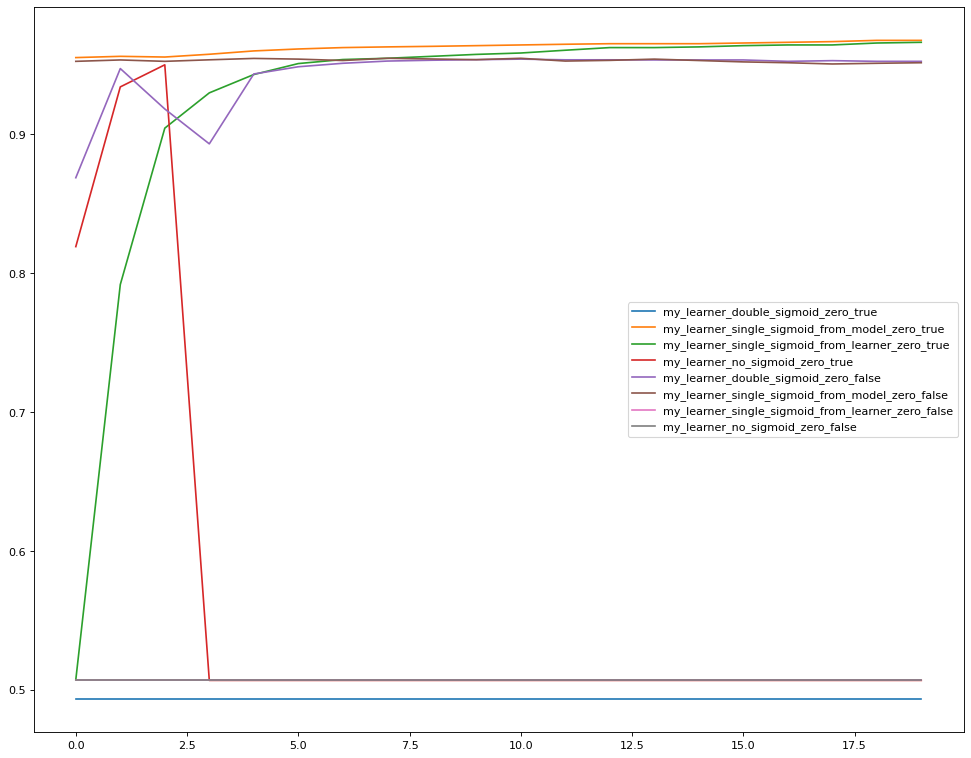

In [21]:
plt.figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

for model in all_models:
    plt.plot(model['model'].valid_loss, label=model['name'])
plt.legend(loc='best')

Hm -- let's plot the ones that performed best.  Our criterion will be "any model that finished with a validation loss above 0.6":

my_learner_single_sigmoid_from_model_zero_true
my_learner_single_sigmoid_from_learner_zero_true
my_learner_double_sigmoid_zero_false
my_learner_single_sigmoid_from_model_zero_false


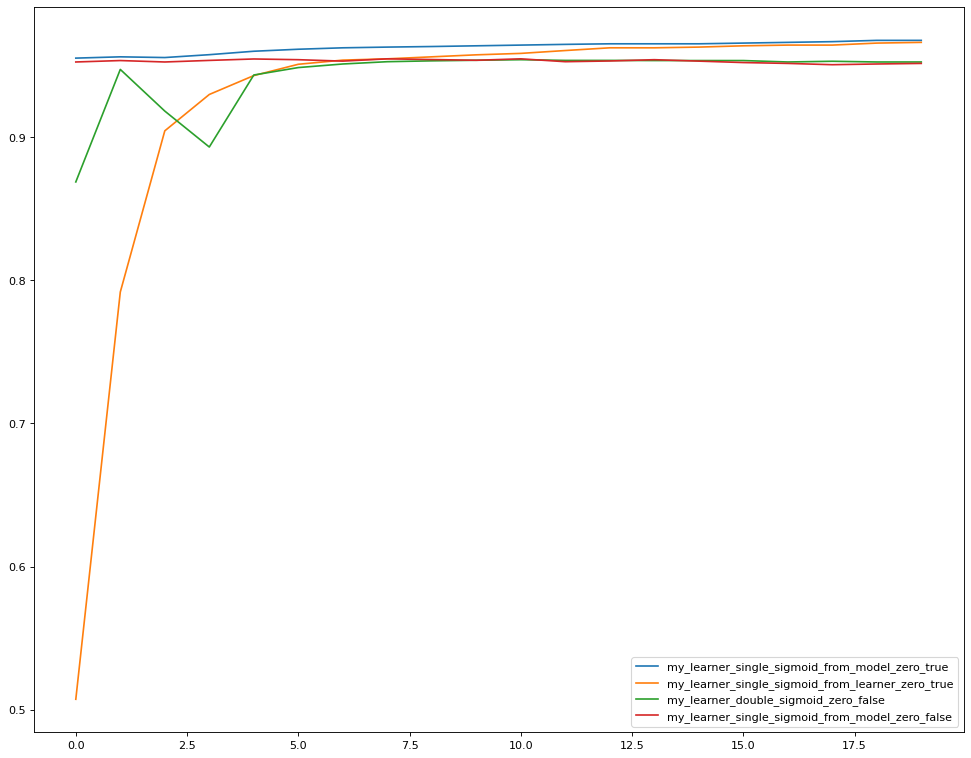

In [22]:
plt.figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

for model in all_models:
    if model['model'].valid_loss[-1] > 0.6:
        # Only show the good ones :-)
        plt.plot(model['model'].valid_loss, label=model['name'])
        print(model['name'])
plt.legend(loc='best')

Four did well...so let's see which four did not:

my_learner_double_sigmoid_zero_true
my_learner_no_sigmoid_zero_true
my_learner_single_sigmoid_from_learner_zero_false
my_learner_no_sigmoid_zero_false


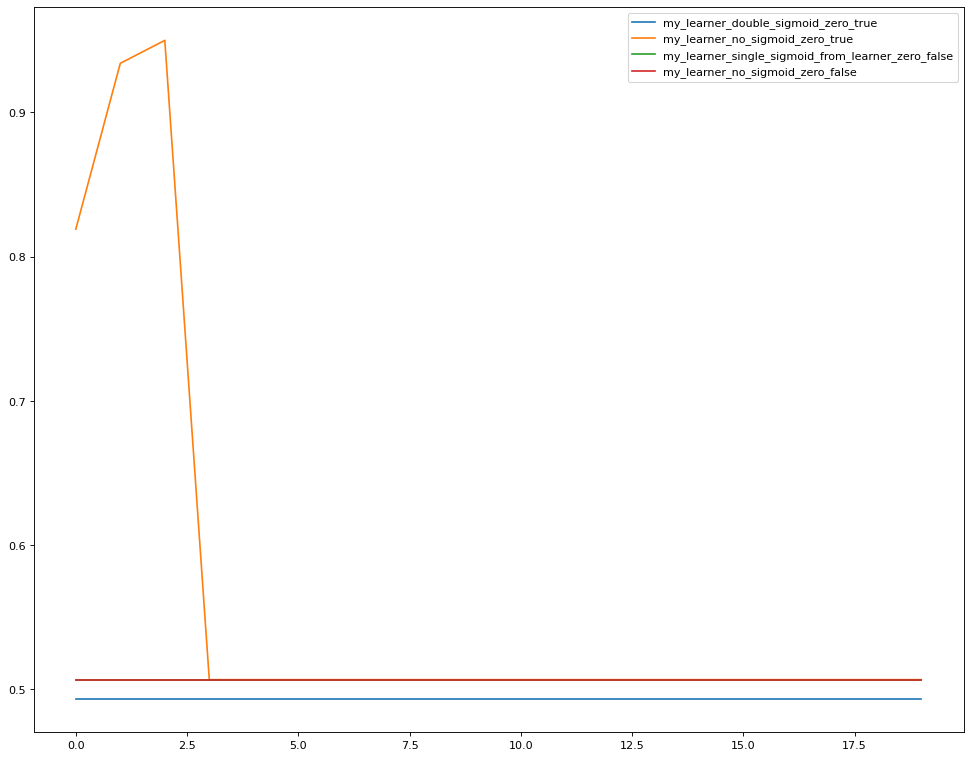

In [23]:
plt.figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

for model in all_models:
    if model['model'].valid_loss[-1] < 0.6:
        # Only show the bad ones :-(
        plt.plot(model['model'].valid_loss, label=model['name'])
        print(model['name'])
plt.legend(loc='best')

Two of those models worked *really* well:  

- sigmoid-in-model/zero-true 
- sigmoid-in-learner/zero-true

The difference between them is that sigmoid-in-model had the sigmoid output in the model itself, with weights that could be adjusted as the model learned; the sigmoid-in-learner just applied the sigmoid function to the output of the model, which itself had *no* sigmoid layer.

Let's see how well those two behaved throughout the epochs:

<Figure size 1200x960 with 0 Axes>

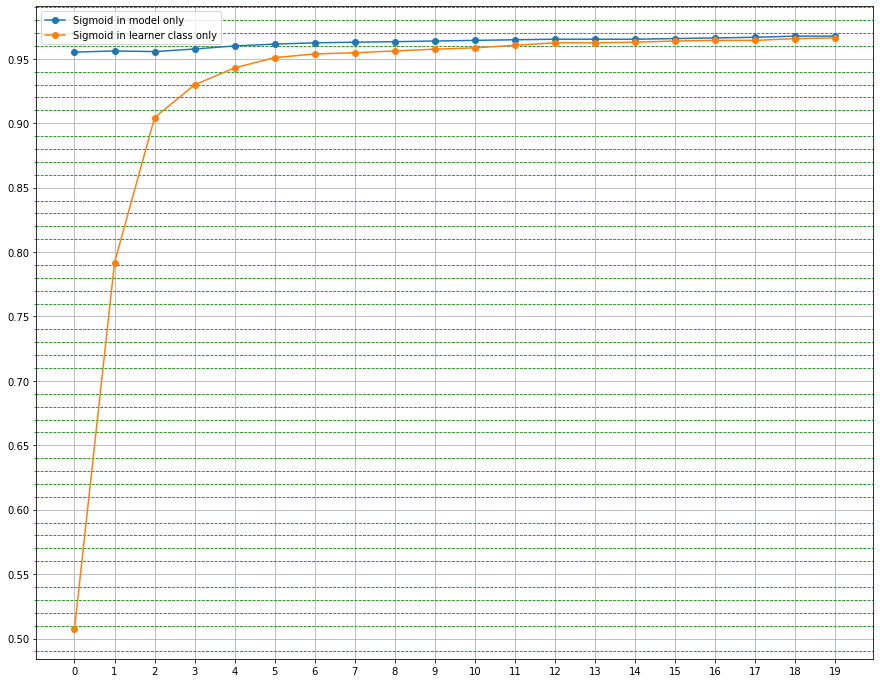

In [24]:
import matplotlib.ticker as plticker

plt.figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots(figsize=(15, 12))

x_loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(x_loc)

y_maj_loc = plticker.MultipleLocator(base=0.05)
y_min_loc = plticker.MultipleLocator(base=0.01)

ax.yaxis.set_major_locator(y_maj_loc)
ax.yaxis.set_minor_locator(y_min_loc)

ax.yaxis.grid(b=True, which='minor', color='g', linestyle='--')


ax.plot(my_learner_single_sigmoid_from_model_zero_true.valid_loss, 
         label="Sigmoid in model only",
         marker="o")
ax.plot(my_learner_single_sigmoid_from_learner_zero_true.valid_loss, 
         label="Sigmoid in learner class only",
         marker="o")
plt.legend(loc='best')
plt.grid()
plt.show()

# So what's going on here?

I interpret the behaviour of the sigmoid-in-model/zero-true model as:
  - Sigmoid function is *really* useful for these predictions.
  - Thus, it starts off really good already
  - And the zero gradient between passes means it improves, though only slightly.
  
I interpret the behaviour of the sigmoid-in-learner/zero true model as:
   - Sigmoid function is still really useful...
   - ...but unlike having it in the model, where the weight of that layer can be adjusted, here we don't have any weights to adjust for the final sigmoid function.
   - So the model needs to catch up to compensate for it.
   - It does so -- dramatically!
   - But it took ~ 12 epochs to catch up to where the sigmoid-in-model/zero-true model *started*.
  
I would expect, therefore, to get better performance from the start (ie, better performance with less training) by putting a final sigmoid layer in the model.

# And the double sigmoid? What was the effect of that?

What about the effect of having *two* sigmoid functions -- one in the model *and* one in the learner?  This effectively turns `sigmoid(x)` into `sigmoid(sigmoid(x))`. 

Let's plot what that looks like:

(0.5044964312734787, 0.6224593312018546, 0.7275076135036415)

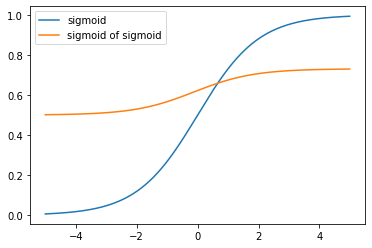

In [25]:
def sigmoid(A):
    return 1/(1+np.exp(-A))

x = np.arange(-5, 5, 0.01)
y = sigmoid(x)
plt.plot(x, y, label="sigmoid")
plt.plot(x, sigmoid(y), label="sigmoid of sigmoid")
plt.legend()
sigmoid(sigmoid(-4)), sigmoid(sigmoid(0)), sigmoid(sigmoid(4))

In other words, `sigmoid(sigmoid(x))` is confined to a narrow range above 0.5, but never higher than ~ 0.7 (even less, because our `x` tops out at 1, not 4).  So it's predicting, but not very confidently, that each image we're looking at will be a 3.  No wonder performance of the double sigma models is not that good.

# What about the models where we didn't zero out the gradients?

We saw that they either start good and decline, or just hover right at 0.5 (ie, performing no better than random chance).

The ones that start well, then decline, are the ones that have a sigmoid function in the model.  I interpret that to mean:

- As posited above, the sigmoid function is really good for this -- so we start strongly.
- But the lack of zeroing gradients means the weights begin to diverge -- so we get worse over time, though slowly.

The ones that just hover around chance are the model with the sigmoid in the learner, and the one with *no* sigmoid at all.  I interpret that to mean:

- No sigmoid == poor performance to start, just as we as with the sigmoid-in-learner/zero-true model up above.
- But no zero gradients mean the weights just keep getting crappier...
- ...so we never do better than random chance.



One more time:  thank you to sahilk1610 (Sahil KARKHANIS) [for posting his exercise](https://forums.fast.ai/t/chapter-4-further-research-building-a-learner-from-scratch/78474); it was a *lot* better than my initial effort, and I'm grateful for the chance to learn from it.